# Getting Started

Install the latest version of QDFlow from the Python Package Index with the
following command:
```bash
pip install qdflow
```

For this tutorial, you will also need the `tutorial_helper.py` file, which
contains helper functions used to streamline plotting the results. This file is
available from the [QDFlow GitHub repository](https://github.com/QDFlow/QDFlow-sim).
Place this file in the same directory as this tutorial notebook.

In [1]:
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

Generating a Charge Stability Diagram with QDFlow is simple.

First, you will need to specify the physical parameters of the device you wish
to simulate. This includes things like the Coulomb interaction strength, the
gate positions and voltages, the locations of the sensors, and other physical
properties of the device. This information is all stored in the `PhysicsParameters`
dataclass.

We can get a `PhysicsParameters` object with default values using `generate.default_physics()`.

In [2]:
# Create a default set of physical parameters
phys = generate.default_physics(n_dots=2)

# Print out some of the parameters 
print("Coulomb interaction strength: %0.2f" % phys.K_0)
print("Number of sensors: %i" % len(phys.sensors))
print("Voltage of left plunger gate: %0.2f" % phys.gates[1].peak)

Coulomb interaction strength: 5.00
Number of sensors: 1
Voltage of left plunger gate: 7.00


A CSD can now be generated with the function `generate.calc_2d_csd()` function.

In [3]:
# Set ranges and resolution of plunger gate sweeps
V_x = np.linspace(2., 14., 70)
V_y = np.linspace(2., 14., 70)

# Run the simulation, this may take ~ 15 seconds
csd = generate.calc_2d_csd(phys, V_x, V_y)

The CSD data is returned as a `CSDOutput` dataclass.

This contains the sensor data, ground truth charge-state labels, and other
metadata such as the physics parameters of the simulated device.

You can obtain the sensor data as a numpy array with shape
`(x_resolution, y_resolution, num_sensors)` by using `csd.sensor`.

**WARNING!**

QDFlow returns 2D data as a numpy array with shape `(x, y)`.
This is opposite of the default behavior of `matplotlib.pyplot.pcolor()`, which
expects shape `(y, x)`.
When plotting data, ensure that the axes are labeled and plotted correctly.

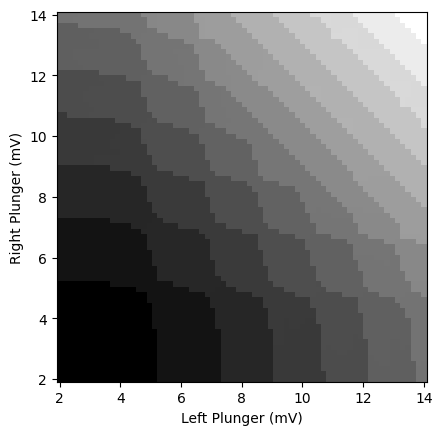

In [4]:
sensor_num = 0 # which sensor to use (by default there's only one,
               # but you can add more by changing phys.sensors)

# Obtain the sensor readout as a numpy array with shape (x_resolution, y_resolution)
sensor_data = csd.sensor[:,:,sensor_num]

# Plot the results
fig, ax = plt.subplots()
tutorial_helper.plot_csd_data(fig, ax, sensor_data, x_y_vals=(csd.V_x, csd.V_y))

We can also obtain the ground-truth labels for the charge state of each pixel
in the diagram.

There are three seperate labels:

* `csd.are_dots_occupied` gives a boolean numpy array with shape
`(x_resolution, y_resolution, num_dots)`. For each pixel `(x, y)` in the CSD,
this array tells whether a given dot has at least 1 charge.

* `csd.are_dots_combined` gives a boolean numpy array with shape
`(x_resolution, y_resolution, num_barriers)`. For each pixel `(x, y)`,
this array tells whether or not the dots on both sides of a given barrier are
combined together (the barrier voltage is too small).

* `csd.dot_charges` gives an integer numpy array with shape
`(x_resolution, y_resolution, num_dots)`. For each pixel `(x, y)`,
this array gives the number of charges in each dot.

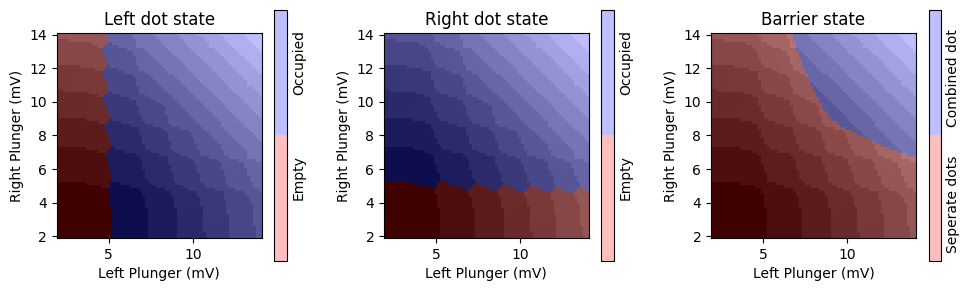

In [5]:
# Obtain dot occupation states
is_left_dot_occupied = csd.are_dots_occupied[:,:,0]
is_right_dot_occupied = csd.are_dots_occupied[:,:,1]

# Obtain barrier state
are_dots_combined = csd.are_dots_combined[:,:,0]

# Plot the results, overlayed with the sensor data
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i in range(3):
    tutorial_helper.plot_csd_data(fig, ax[i], sensor_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Left dot state")
tutorial_helper.overlay_boolean_data(fig, ax[0], is_left_dot_occupied,
                x_y_vals=(csd.V_x, csd.V_y), labels=("Empty", "Occupied"))
ax[1].set_title("Right dot state")
tutorial_helper.overlay_boolean_data(fig, ax[1], is_right_dot_occupied,
                x_y_vals=(csd.V_x, csd.V_y), labels=("Empty", "Occupied"))
ax[2].set_title("Barrier state")
tutorial_helper.overlay_boolean_data(fig, ax[2], are_dots_combined,
                x_y_vals=(csd.V_x, csd.V_y), labels=("Seperate dots", "Combined dot"))
fig.tight_layout()

The transitions can be obtained from these charge states using
`generate.calc_transitions()`.

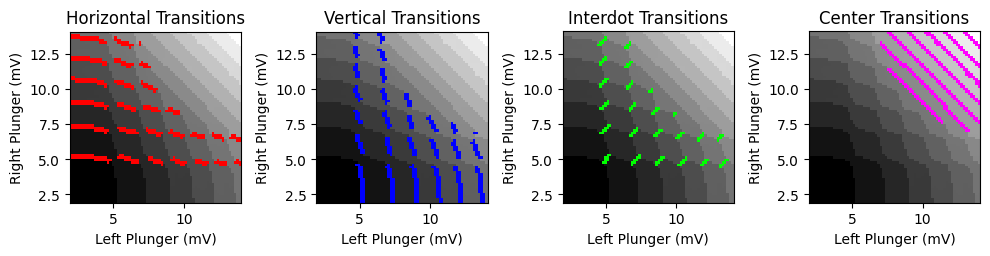

In [6]:
# Calculate transitions from charge states
is_transition, is_transition_combined = generate.calc_transitions(
                            csd.dot_charges, csd.are_dots_combined)


# Vertical transitions occur when there is a transition
# in the left dot but NOT the right dot
vertical_transitions = is_transition[:,:,0] & ~is_transition[:,:,1]

# Horizontal transitions occur when there is a transition
# in the right dot but NOT the left dot
horizontal_transitions = ~is_transition[:,:,0] & is_transition[:,:,1]

# Interdot transitions occur when there is a transition
# in both dots but they are NOT combined together
interdot_transitions = (is_transition[:,:,0] & is_transition[:,:,1]
                        & ~is_transition_combined[:,:,0])

# Center transitions occur when there is a transition in a combined center dot
center_transitions = is_transition_combined[:,:,0]


# Plot the results, overlayed with the sensor data
fig, ax = plt.subplots(1, 4, figsize=(10,2.5))
for i in range(4):
    tutorial_helper.plot_csd_data(fig, ax[i], sensor_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Horizontal Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[0], horizontal_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(1,0,0,1)))
ax[1].set_title("Vertical Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[1], vertical_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(0,0,1,1)))
ax[2].set_title("Interdot Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[2], interdot_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(0,1,0,1)))
ax[3].set_title("Center Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[3], center_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(1,0,1,1)))
fig.tight_layout()